In [1]:
import matplotlib.pyplot as plt
import numpy             as np
import pandas            as pd
import seaborn           as sns
import os
import torch
import json

from libraries.model   import Helmholtz_free_energy_function, make_predictions, GCNN, compute_coefficients, compute_Fv
from libraries.dataset import load_atomic_masses, include_temperatures, create_predictions_dataset, standardize_dataset_from_keys

#import ML_library        as MLL
import sys
import os

sys.path.append('../../UPC')
import Database.DB_library as DBL
import MP.MP_library       as MPL

# Checking if pytorch can run in GPU, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sns.set_theme()

In [2]:
model_folder    = 'model'  # Pre-trained model and dataset parameters
data_folder     = 'example-data'  # Example coefficients and labels of the target database
output_folder   = 'output'  # Output files and figures
input_folder    = 'input'  # General files (e.g., atomic masses information)
target_database = 'target_dataset'  # Target database

# Whether to plot the harmonic extrapolations of Fv (very time-consuming) or not
plot_extrapolations = False

# Defining the range of temperatures
Ti = 300
Tf = 600
dT = 50
temperatures = np.arange(Ti, Tf+dT, dT)  # Temperatures for prediction of free-energies

# Loading dictionary of atomic masses
atomic_masses = load_atomic_masses(f'{input_folder}/atomic_masses.dat')

In [3]:
# Load the data from the JSON file
with open(f'{model_folder}/standardized_parameters.json', 'r') as json_file:
    numpy_dict = json.load(json_file)

# Convert NumPy arrays back to PyTorch tensors
standardized_parameters = {}
for key, value in numpy_dict.items():
    try:
        standardized_parameters[key] = torch.tensor(value)
    except:
        standardized_parameters[key] = value

# Load reference dataset for uncertainty estimation
reference_dataset = torch.load(f'{model_folder}/ref_std_dataset.pt', weights_only=False)

NaH


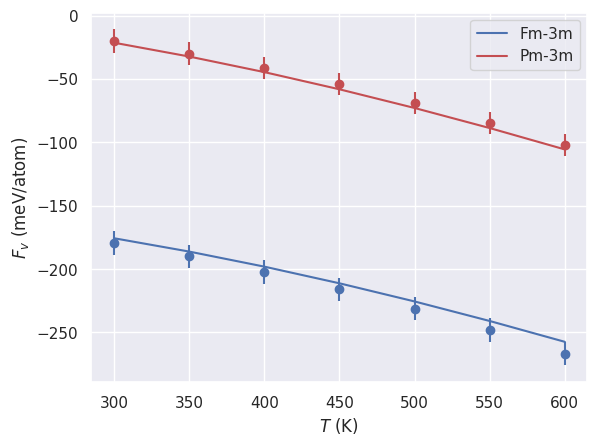

MgS


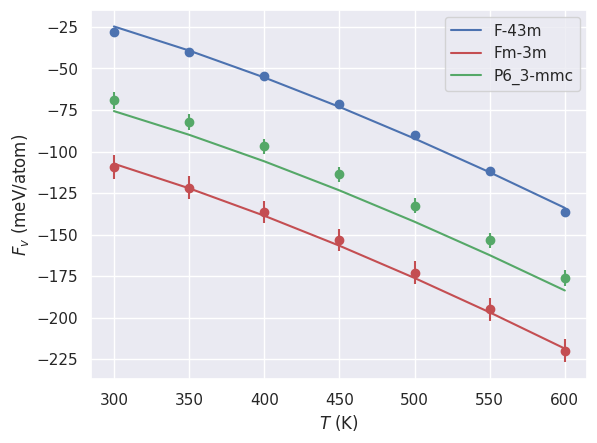

In [4]:
colors = ['b', 'r', 'g', 'k']

materials = {
    'BH6N': ['Cmc2_1', 'Pmn2_1'],
    'CaBH42': ['Fddd', 'I-42d'],
    'Li2FeCoO4': ['C2-c', 'R-3m'],
    'NaH': ['Fm-3m', 'Pm-3m'],
    'NaHO': ['P4-nmm', 'R3m'],
    'RbCuTe': ['P6_3-mmc', 'P6_3-mmc_2'],
    'RbAgSe': ['Cmcm', 'P4-nmm', 'P6_3-mmc', 'P6_3-mmc_2'],
    'MgS': ['F-43m', 'Fm-3m', 'P6_3-mmc'],
    'BaCl2': ['I4-mmm', 'P-62m'],
    'NaZnP': ['P4-nmm', 'P6_3-mmc', 'P6_3-mmc_2'],
    'RbScO2': ['P6_3-mmc', 'R-3m'],
    'CsYO2': ['P6_3-mmc', 'R-3m', 'R-3m_2'],
    'MgF2': ['P2_1-c', 'P-3m1', 'Pnnm', 'R-3m']
}

offsets = {
    'BH6N': 4522.343993936683,
    'CaBH42': 4144.65534897643,
    'Li2FeCoO4': 6516.480859677684,
    'NaH': 2403.016851739045,
    'NaHO': 4592.32568074285,
    'RbCuTe': 3509.4943688973763,
    'RbAgSe': 3368.582337527254,
    'MgS': 4428.2409955455005,
    'BaCl2': 4597.253871079191,
    'NaZnP': 3318.473003078988,
    'RbScO2': 7213.586284609213,
    'CsYO2': 7243.982865534706,
    'MgF2': 5273.468082416714
}

materials = {
    'NaH': ['Fm-3m', 'Pm-3m'],
    'MgS': ['F-43m', 'Fm-3m', 'P6_3-mmc']
}

offsets = {
    'NaH': 2403.016851739045,
    'MgS': 4428.2409955455005
}

for material in materials.keys():
    print(material)

    polymorphs = materials[material]
    
    for idx in range(len(polymorphs)):
        path_to_EPA    = f'/home/claudio/Desktop/validation-phonons/{material}/{polymorphs[idx]}'
        path_to_POSCAR = f'{path_to_EPA}'
        path_to_PHONON = f'{path_to_EPA}'
        
    
        # PHONON
        
        # Loading number of atoms
        _, _, concentration, _ = MPL.information_from_VASPfile(path_to_PHONON, file='POSCAR')
        n_atoms = np.sum(concentration)
        
        # Reading supercell information
        dim_info = MPL.read_phonopyconf(path_to_PHONON)
        
        # Write mesh.conf file (needed for phonopy)
        MPL.write_meshconf(path_to_PHONON, material, dim_info, Ti, Tf, dT)
        
        # Getting thermal properties with phonopy (ignoring output)
        previous_dir = os.getcwd()
        os.chdir(path_to_PHONON)
        os.system('phonopy -t mesh.conf > /dev/null')
        os.chdir(previous_dir)
        
        # Read generated thermal properties (kJ/mol)
        try:
            _, Fv_PHONON = MPL.read_thermalpropertyyaml(len(temperatures), path_to_PHONON, thermalproperty='free_energy')
        except FileNotFoundError:  # Some calculation not finished
            sys.exit('PHONON calculation not finished.')
        
        # Pass kJ / molmp-1009220 to meV / atom
        conversion_factor = 1.6 * 6.022 * 0.01 * n_atoms
        Fv_PHONON        /= conversion_factor
        
        
        # ML

        
        # Create dataset for predictions
        dataset = create_predictions_dataset(path_to_POSCAR, path_to_material=True, path_to_polymorph=True)
        
        labels = [graph.label for graph in dataset]
        
        # Standardize properties
        std_dataset = standardize_dataset_from_keys(dataset, standardized_parameters)
        
        # Load Graph Neural Network model (making room for temperature as node attribute) to device
        # Dropout for initializing the model, not used at all while predicting
        model = GCNN(features_channels=dataset[0].num_node_features+1,
                     pdropout=0).to(device)
        
        # Free-up CUDA
        del dataset
        
        # Load and evaluate Graph Neural Network model
        model.load_state_dict(torch.load(f'{model_folder}/model.pt', map_location=torch.device(device)))
        model.eval()
        
        # Include temperatures
        std_dataset_w_temp = include_temperatures(std_dataset, temperatures, standardized_parameters)
        
        # Free-up CUDA
        del std_dataset
        
        # Compute predictions and corresponding uncertainties
        shot_predictions, shot_uncertainties = make_predictions(reference_dataset, std_dataset_w_temp, model, standardized_parameters)
        
        # Free-up CUDA
        del std_dataset_w_temp
        
        # Computing the coefficients and uncertainties from fitting
        coefficients = compute_coefficients(temperatures, shot_predictions, shot_uncertainties, s=1000)

        # Compute Fv
        Fv_pred = compute_Fv(temperatures, coefficients)
                
        # Plotting
        
        FP  = Fv_PHONON
        FM  = Fv_pred[0]
        
        epa = float(np.loadtxt(f'{path_to_PHONON}/EPA')) * 1e3  # From eV/atom to meV/atom
        
        plt.plot(temperatures,     epa+FP+offsets[material], color=colors[idx], label=f'{polymorphs[idx]}')
        plt.errorbar(temperatures, epa+FM+offsets[material], color=colors[idx], yerr=shot_uncertainties, fmt='o')
    
        
    plt.xlabel(r'$T$ (K)')
    plt.ylabel(r'$F_v$ (meV/atom)')
    plt.legend(loc='best')
    plt.savefig(f'{path_to_PHONON}/{material}.pdf', dpi=50, bbox_inches='tight')
    plt.show()

In [5]:
shot_uncertainties

array([5.0148783, 4.7221956, 4.484313 , 4.342781 , 4.369218 , 4.4786863,
       4.6665053], dtype=float32)

In [6]:
# Agora dividimos por 8.78 no canto de por 244.57